In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf  
import os
from plotly.offline import plot
import plotly.graph_objs as go
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
# Set TensorFlow logging level to suppress detailed logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
def get_stock_data(ticker, start_date, end_date):
    """
    This function is designed to fetch historical stock data
    @param ticker: Stock ticker symbol
    @param start_date: Start date for fetching data (YYYY-MM-DD)
    @param end_date: End date for fetching data (YYYY-MM-DD)
    @return: DataFrame containing historical stock data
    """
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    data = yf.Ticker(ticker)
    new_data = data.history(start=start_date, end=end_date)
    if new_data.empty:
        raise ValueError("No data found for the given ticker and date range.")
    return new_data

In [3]:
def transformed_data(data):
    """
    This function transforms the index of the DataFrame to datetime format
    it also drops unnecessary columns
    @param data: DataFrame containing stock data
    @return: DataFrame with datetime index
    """
    data = data.drop(columns=['Dividends', 'Stock Splits'], axis=1)
    data.index = pd.to_datetime(data.index)
    return data

In [4]:
data = get_stock_data("MSFT", '2000-01-03', '2025-09-01')

In [5]:
data.head

<bound method NDFrame.head of                                  Open        High         Low       Close  \
Date                                                                        
2000-01-03 00:00:00-05:00   35.916704   36.299204   34.271956   35.668079   
2000-01-04 00:00:00-05:00   34.750086   35.840210   34.348461   34.463211   
2000-01-05 00:00:00-05:00   34.004214   35.610712   33.468714   34.826588   
2000-01-06 00:00:00-05:00   34.329344   34.845718   33.162720   33.659969   
2000-01-07 00:00:00-05:00   33.239196   34.348444   32.837571   34.099819   
...                               ...         ...         ...         ...   
2025-08-25 00:00:00-04:00  506.630005  508.190002  504.119995  504.260010   
2025-08-26 00:00:00-04:00  504.359985  504.980011  498.510010  502.040009   
2025-08-27 00:00:00-04:00  502.000000  507.290009  499.899994  506.739990   
2025-08-28 00:00:00-04:00  507.089996  511.089996  505.500000  509.640015   
2025-08-29 00:00:00-04:00  508.660004  509.600

In [6]:
def plot_stock_data(data, title):
    """
    This function is built to plot the opening and closing price data of the stock
    @param data: DataFrame containing stock data
    @param title: The title prefered for the plot
    """
    data.plot(subplots=True, figsize=(12, 14))
    plt.figure(figsize=(12, 8))
    plt.plot(data['Close'], label="Closing Price", color='blue', lw=1.5, linestyle="--")
    plt.plot(data['Open'], label="Opening Price", color='red', lw=1.3)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

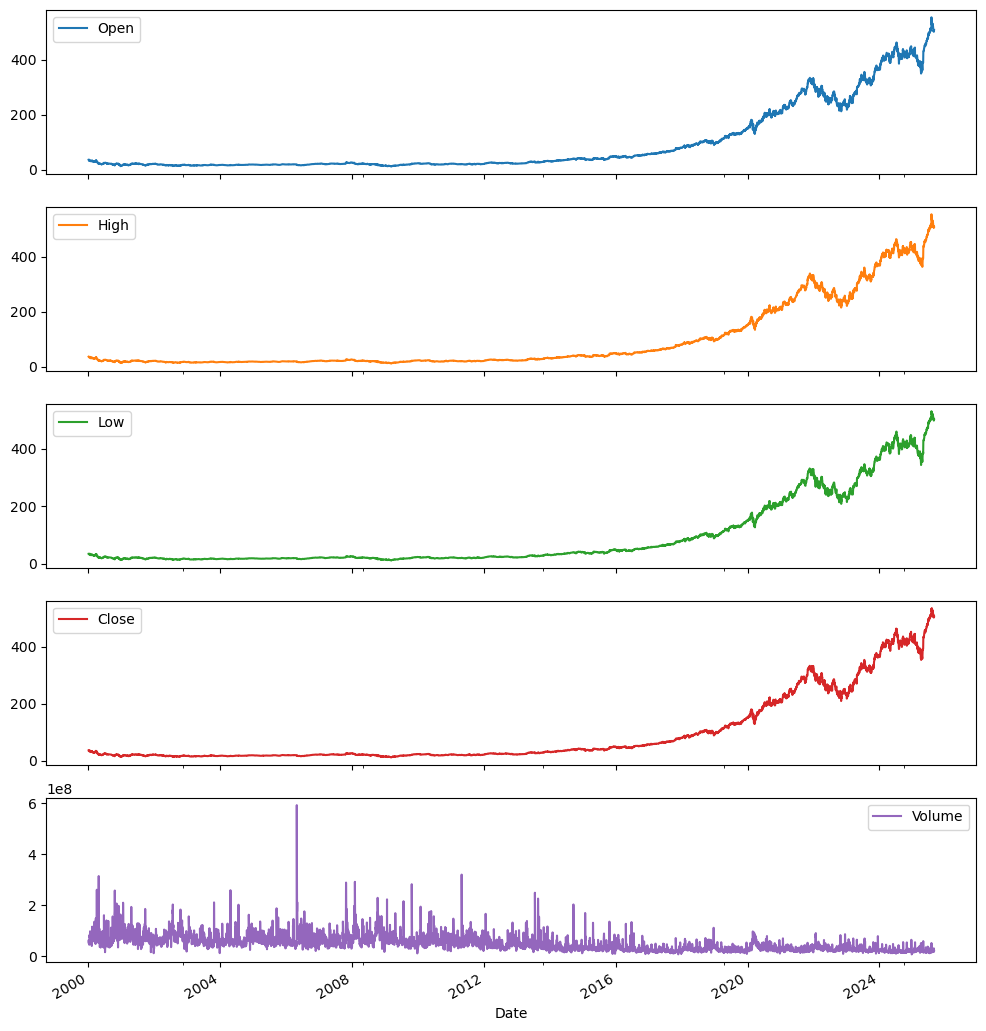

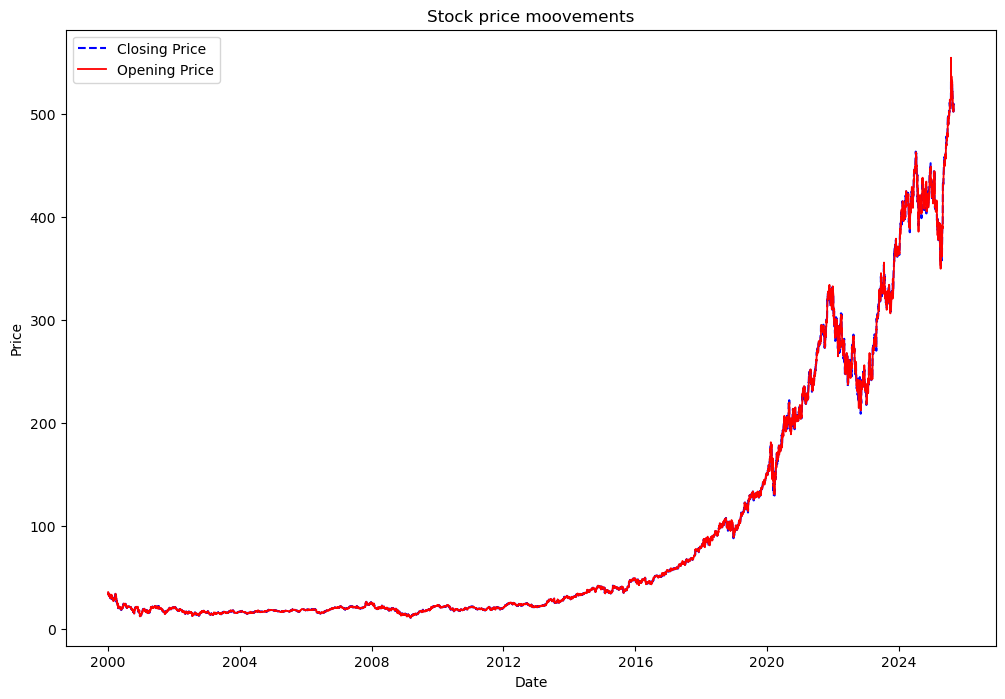

In [7]:
plot_stock_data(data.drop(["Dividends",	"Stock Splits"], axis=1) ,  title="Stock price moovements")

In [8]:
def normalise_data(data):
    """
    This function normalises the close price of the stock data for model development
    @param data: DataFrame containing stock data
    @return: Scaled data object
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = data.copy()
    scaled_data["Close"] = scaler.fit_transform(data[["Close"]])
    scaled_data["High"] = scaler.fit_transform(data[["High"]])
    scaled_data["Low"] = scaler.fit_transform(data[["Low"]])
    scaled_data["Open"] = scaler.fit_transform(data[["Open"]])
    scaled_data["Volume"] = scaler.fit_transform(data[["Volume"]])
    return scaled_data, scaler

In [9]:
data_normalised, scaler = normalise_data(data.drop(["Dividends", "Stock Splits"], axis = 1))

In [10]:
data_normalised.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03 00:00:00-05:00,0.045515,0.045658,0.044837,0.046808,0.078892
2000-01-04 00:00:00-05:00,0.043367,0.044812,0.044985,0.044507,0.080417
2000-01-05 00:00:00-05:00,0.041994,0.044390,0.043293,0.045201,0.097442
2000-01-06 00:00:00-05:00,0.042593,0.042981,0.042705,0.042973,0.081886
2000-01-07 00:00:00-05:00,0.040586,0.042065,0.042079,0.043813,0.093938


In [11]:
def plotting_with_plotly(data):
    """
    This function plots the stock data using plotly so that we can see the price movements
    using candlestick charts
    The color indicates whether the stock closed higher (green) or lower (red) than it opened
    @param data: DataFrame containing stock data
    @param title: The title prefered for the plot
    """
    trace = go.Ohlc(x=data.index, 
                    open=data['Open'], 
                    high=data['High'], 
                    low=data['Low'], 
                    close=data['Close'], 
                    name='OHLC Charts of the price movements')
    fig = go.Figure(data=[trace])
    plot(fig)

In [12]:
plotting_with_plotly(data_normalised)

In [13]:
def moving_average(data, window_size1=20, window_size2 = 50, window_size3 = 10):
    """
    This function calculates the moving average of the stock's closing price
    @param data: DataFrame containing stock data
    @param window_size: The window size for calculating the moving average (default is 50)
    @return: Series containing the moving average
    """
    ma1 = data['Close'].rolling(window=window_size1).mean()
    ma2 = data['Close'].rolling(window=window_size2).mean()
    ma3 = data['Close'].rolling(window=window_size3).mean()
    plt.figure(figsize=(12, 6))
    plt.plot(data["Close"], label='Closing Price', color = "red")
    plt.plot(ma1, label=f'{window_size1}-Days Moving Average', color='blue')
    plt.plot(ma2, label=f'{window_size2}-Days Moving Average', color='green')
    plt.plot(ma3, label=f'{window_size3}-Days Moving Average', color='black')
    plt.title(f'Plot of the Closing price and its {window_size1}-, {window_size2}-, and {window_size3}-Days Moving Average')
    plt.legend()
    plt.show()


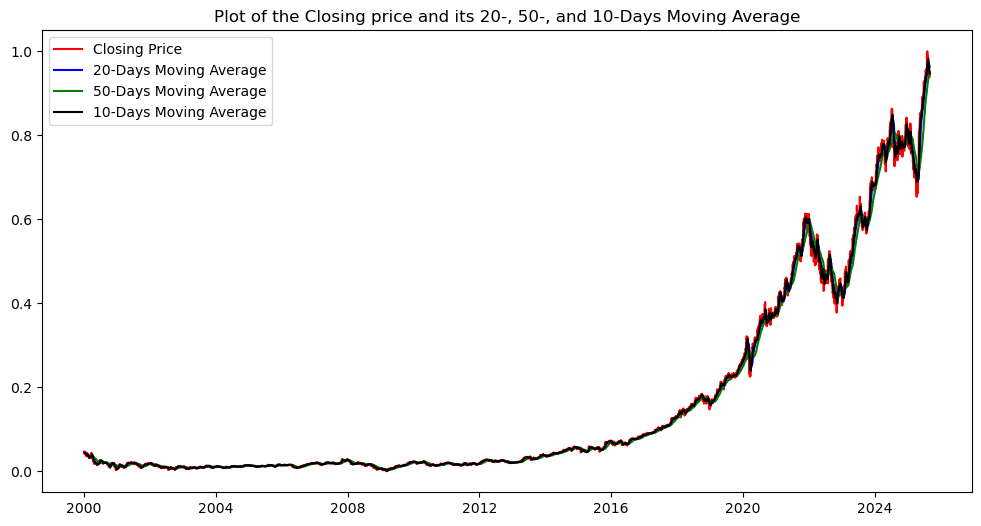

In [14]:
moving_average(data_normalised)

In [15]:
def data_train_test(data):
    """
    This function separates the data into training and testing sets
    @param data: DataFrame containing stock data
    @param train_size: Proportion of data to be used for training (default is 0.8)
    @return: Training and testing datasets
    """
    Close = data[["Close"]]
    train = Close[Close.index < '2022-01-01']
    test = Close[Close.index >= '2022-01-01']
    print(f"The shape of the training data is: {train.shape}")
    print(f"The shape of the testing data is: {test.shape}")
    return train, test

In [16]:
train, test = data_train_test(data_normalised)

The shape of the training data is: (5536, 1)
The shape of the testing data is: (918, 1)


In [17]:
def create_timeseries_generator(train, test, n_input=30):
    """
    This function creates a time series generator for the stock data
    @param train: DataFrame containing the train stock data
    @param test: DataFrame containing the test stock data
    @return: TimeseriesGenerator object
    """
    train_array = train.values
    test_array = test.values

    train_gen = TimeseriesGenerator(train_array, 
                                    train_array, 
                                    length=n_input, 
                                    batch_size=32, 
                                    shuffle=False,
                                    sampling_rate=1,
                                    stride=1)

    test_gen = TimeseriesGenerator(test_array, 
                                   test_array,
                                   length=n_input,
                                   batch_size=32,
                                   shuffle=False,
                                   sampling_rate=1)
    return train_gen, test_gen

In [18]:
def lstm_model(n_neuron = 8, n_input=30):
    n_features = 1
    n_input = n_input
    model = Sequential()
    model.add(LSTM(n_neuron,  
                   input_shape=(n_input, n_features))
                   )
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics = ["mse"])
    return model

In [19]:
def run_model(model, train_gen, epochs=200):
    """
    This function runs the LSTM model on the training and testing data
    @param model: The LSTM model to be trained
    @param train_gen: TimeseriesGenerator object for training data
    @param epochs: Number of epochs to train the model (default is 50)
    @return: History object containing training history
    """
    history = model.fit(train_gen, 
                        epochs=epochs, 
                        verbose=1)
    return history

In [20]:
def example_with_Microsoft_stock(ticker = 'MSFT'):
    """
    This function is an example of how to use the above functions with Microsoft stock data
    @param ticker: Stock ticker symbol (default is 'MSFT' for Microsoft)
    """
    data = get_stock_data(ticker, '2000-01-03', '2025-09-01')
    new_data = data.copy()
    new_data = transformed_data(new_data)
    #plot_stock_data(new_data, f"{ticker} Stock Price Data")
    data_scaled, scaler = normalise_data(new_data)
    train, test = data_train_test(data_scaled)
    train_gen, test_gen = create_timeseries_generator(train, test, n_input=30)
    model = lstm_model(n_neuron=8, n_input=300)
    history = run_model(model, train_gen, epochs=100)
    #print(type(data_scaled))
    #print(data_scaled.head())
    return history, model, test, test_gen, scaler

The shape of the training data is: (5536, 1)
The shape of the testing data is: (918, 1)


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
 18/173 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0342 - mse: 0.0342

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0123 - mse: 0.0123
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7993e-04 - mse: 3.7993e-04
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.0938e-04 - mse: 2.0938e-04
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.7039e-04 - mse: 1.7039e-04
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4855e-04 - mse: 1.4855e-04
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3645e-04 - mse: 1.3645e-04
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1276e-04 - mse: 1.1276e-04
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1958e-04 - mse: 1.1958e-04
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0830e-04 - mse: 1.0830e-04
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0744e-04 - mse: 1.0744e-04
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.3959e-05 - mse: 8.3959e-05
Epoch 12/100
173/1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 989 (3.87 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 660 (2.58 KB)

None


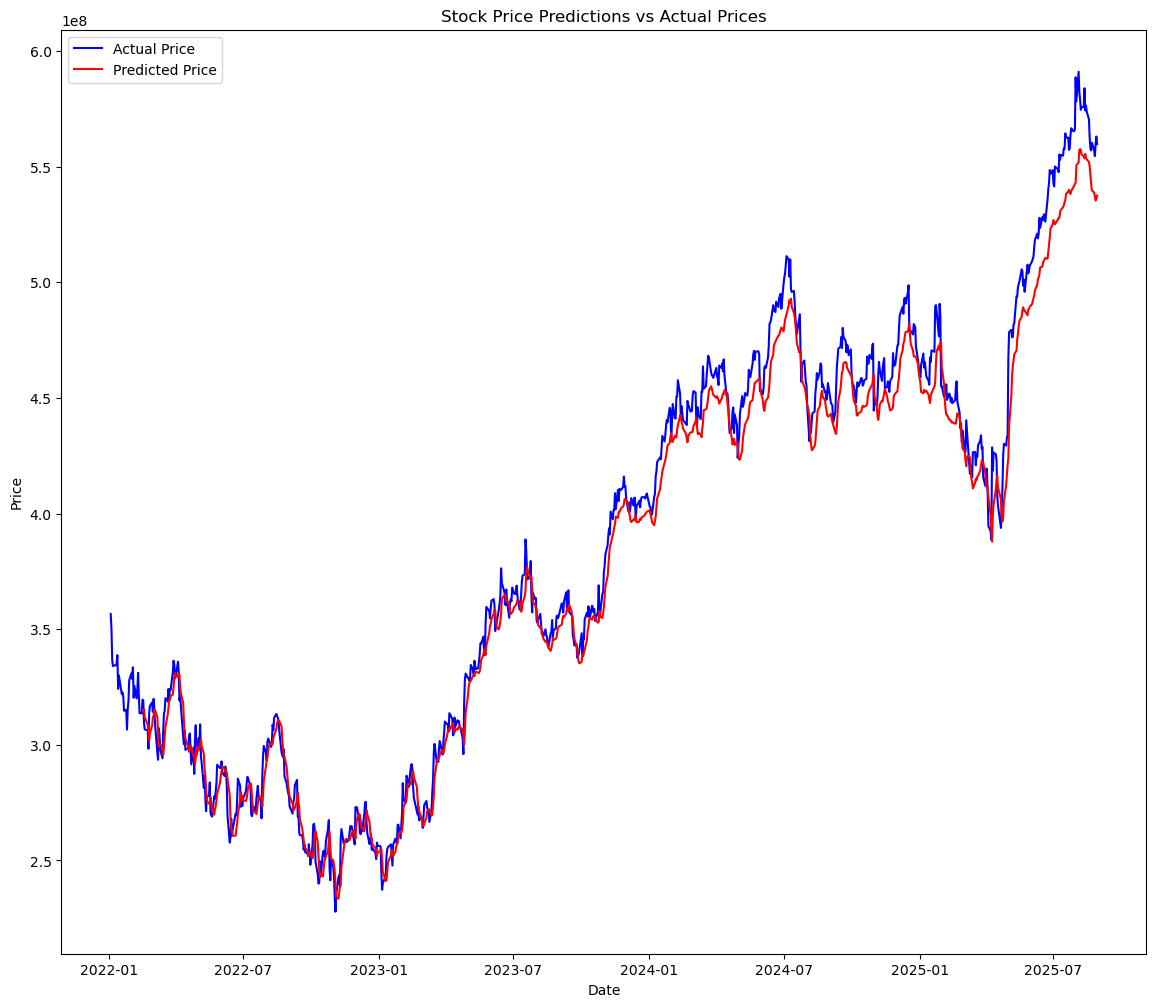

<Figure size 640x480 with 0 Axes>

In [21]:
if __name__ == "__main__":
    history, model, test, test_gen, scaler = example_with_Microsoft_stock('MSFT')
    #data.describe()
    #print(f"The total number of null values per variable is:\n {data.isnull().sum()}")
    #print(f"The shape of the dataset is: {data.shape}")
    #print(f"The columns of the dataset are: {data.columns}")
    #plotting_with_plotly(data, title="Microsoft Stock Price Data")
    #moving_average(data, window_size=50)
    predictions = model.predict(test_gen)
    test['Close'] = scaler.inverse_transform(test[['Close']])
    test_predictions   = scaler.inverse_transform(predictions)
    print(model.summary())
    plt.figure(figsize=(14, 12))
    plt.plot(test.index, test['Close'], label='Actual Price', color='blue')
    plt.plot(test.index[30:], test_predictions, label='Predicted Price', color='red')
    plt.title('Stock Price Predictions vs Actual Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    plt.savefig('stock_price_predictions.png')

 32/173 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 989 (3.87 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 660 (2.58 KB)

None


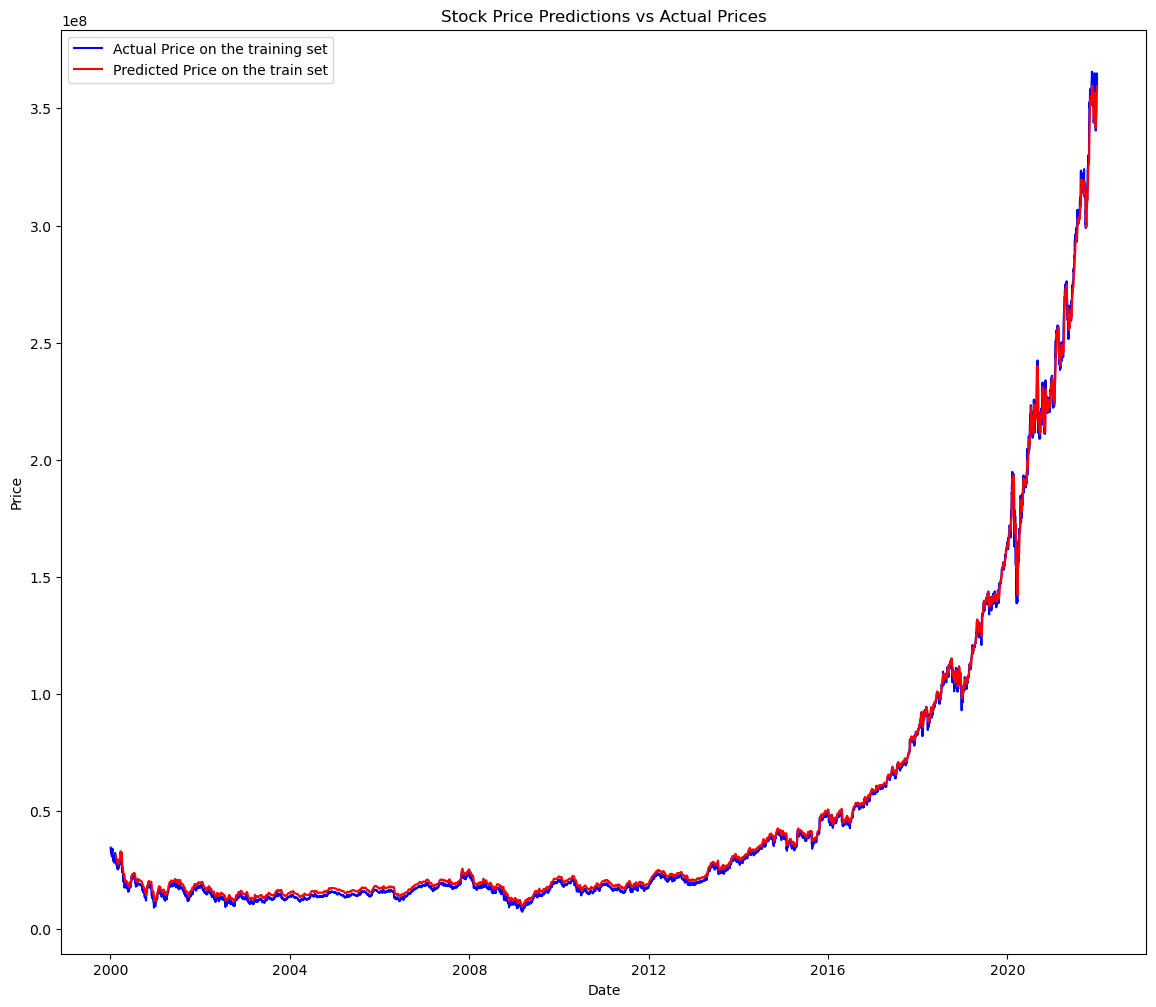

<Figure size 640x480 with 0 Axes>

In [22]:
if __name__ == "__main__":   
    
    train_gen, test_gen = create_timeseries_generator(train, test, n_input=30)
    predictions = model.predict(train_gen)
    train['Close'] = scaler.inverse_transform(train[['Close']])
    train_predictions   = scaler.inverse_transform(predictions)
    print(model.summary())
    plt.figure(figsize=(14, 12))
    plt.plot(train.index, train['Close'], label='Actual Price on the training set', color='blue')
    plt.plot(train.index[30:], train_predictions, label='Predicted Price on the train set', color='red')
    plt.title('Stock Price Predictions vs Actual Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    plt.savefig('stock_price_predictions.png')

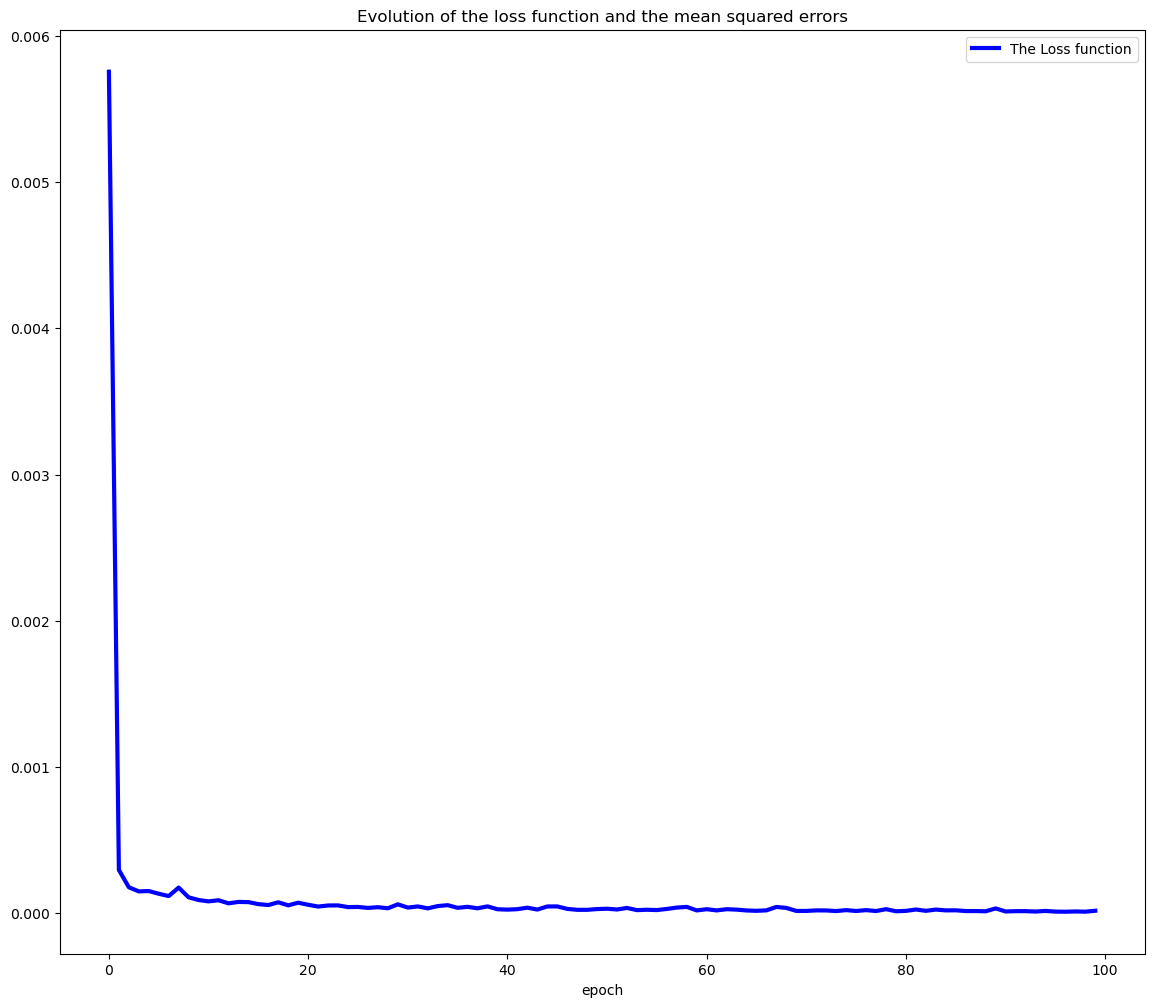

<Figure size 640x480 with 0 Axes>

In [36]:
plt.figure(figsize=(14, 12))
plt.plot(history.epoch, history.history["loss"], label='The Loss function', color='blue', lw=3)
#plt.plot(history.epoch, history.history["mse"], label='The mean_squared_error', color='red')
plt.title('Evolution of the loss function and the mean squared errors')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.savefig('stock_price_predictions.png')